# Libraries and Params

In [1]:
# Importing libraries
import os
import cv2
import random 
import numpy as np 
import pandas as pd 
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import label_binarize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0, InceptionV3
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, concatenate, Conv2D, MaxPooling2D, Flatten
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc

In [2]:
# Settig parameters
IMAGE_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15
LEARNING_RATE = 1e-4
NUM_CLASSES = 3

# Data Exploration

In [3]:
# Ignoring warning messages
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Loading the dataset CSV files
train = pd.read_csv('/kaggle/input/aptos2019-blindness-detection/train.csv')
train.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [5]:
# Displaying number of samples
print('Number of train samples: ', train.shape[0])

Number of train samples:  3662


In [6]:
print("\nTrain dataset info:")
train.info()


Train dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3662 entries, 0 to 3661
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id_code    3662 non-null   object
 1   diagnosis  3662 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 57.3+ KB


In [7]:
print("\nTrain dataset description:")
print(train.describe())


Train dataset description:
         diagnosis
count  3662.000000
mean      1.126980
std       1.298409
min       0.000000
25%       0.000000
50%       1.000000
75%       2.000000
max       4.000000


In [8]:
# Checking missing values
print("Missing Values in Train:\n", train.isnull().sum())

Missing Values in Train:
 id_code      0
diagnosis    0
dtype: int64


In [9]:
train.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


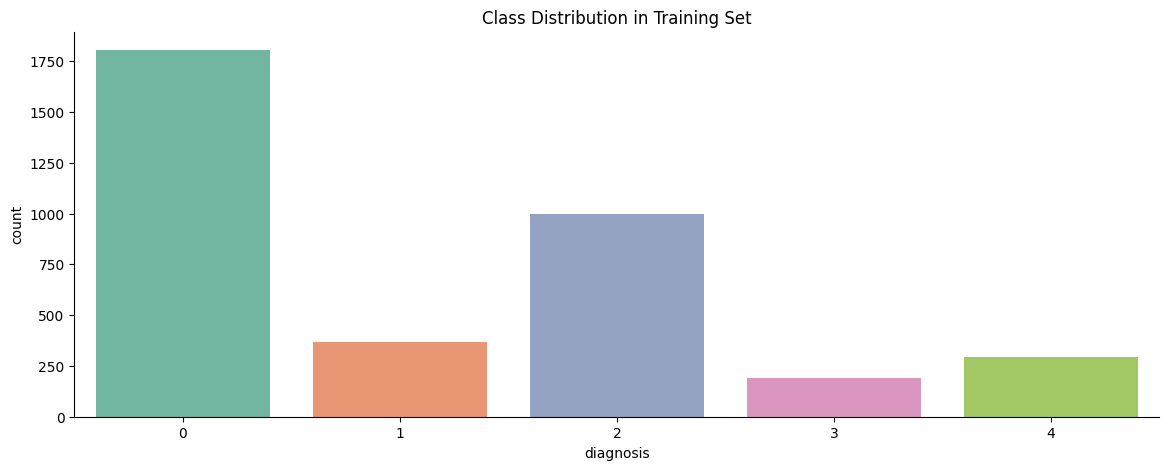

In [10]:
# class distribution in the training set
f, ax = plt.subplots(figsize=(14, 5))
ax = sns.countplot(x="diagnosis", data=train, palette="Set2")
sns.despine()
plt.title("Class Distribution in Training Set")
plt.show()

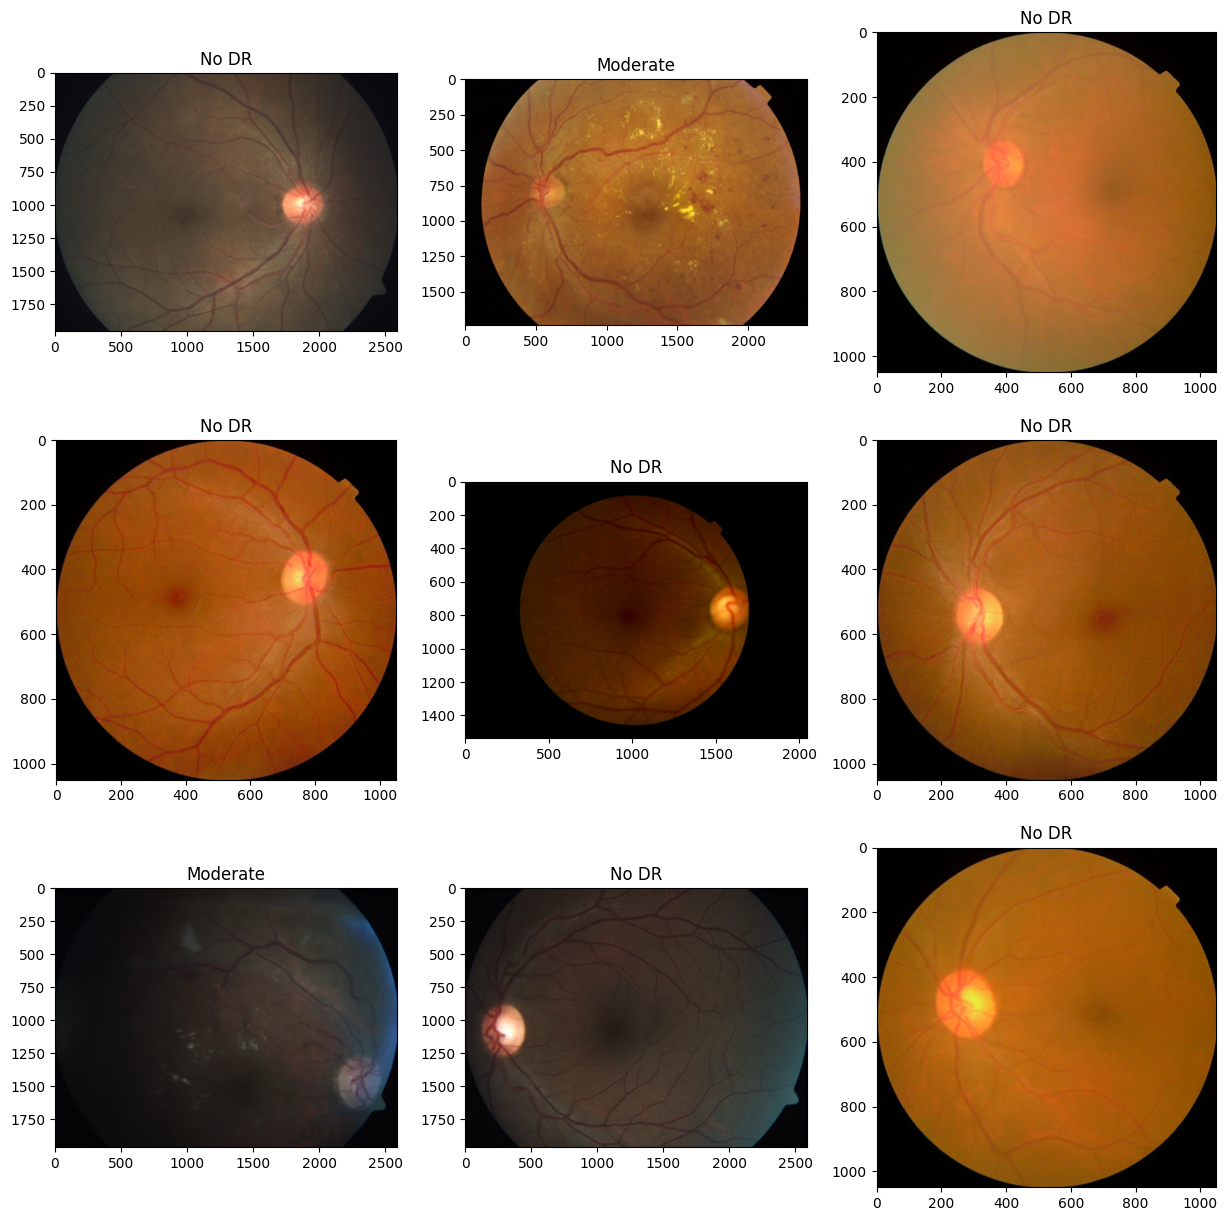

In [11]:
label_dic = {
    "0":"No DR",
    "1" : "Mild",
    "2":"Moderate",
    "3":"Severe",
    "4":"Proliferative DR"
}

#Checking Some Samples and Their Label

rows=3
cols = 3
count = 0

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15,15))

indx = random.sample(range(train.shape[0]),rows * cols)

for i in range(rows):
    for j in range(cols):        
        if count < len(indx):
            img_path = "/kaggle/input/aptos2019-blindness-detection/train_images/"+train.iloc[indx[count],0]+".png"
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i, j].imshow(img)
            axes[i,j].set_title(label_dic[str(train.iloc[indx[count],1])])
            count+=1

In [12]:
# Appending '.png' to file names
train["id_code"] = train["id_code"].apply(lambda x: x + ".png")

# Creating Copy
df_origional = train.copy()

# Combining classes into 3 categories
train['diagnosis'] = train['diagnosis'].replace({0: 0, 1: 1, 2: 1, 3: 2, 4: 2})

label_dict = {
    0: 'No Disease',
    1: 'Mild Disease',
    2: 'Severe Disease'
}

class_distribution = train['diagnosis'].value_counts().sort_index()
class_distribution.index = class_distribution.index.map(label_dict)

print("Updated class distribution:\n", class_distribution)

Updated class distribution:
 diagnosis
No Disease        1805
Mild Disease      1369
Severe Disease     488
Name: count, dtype: int64


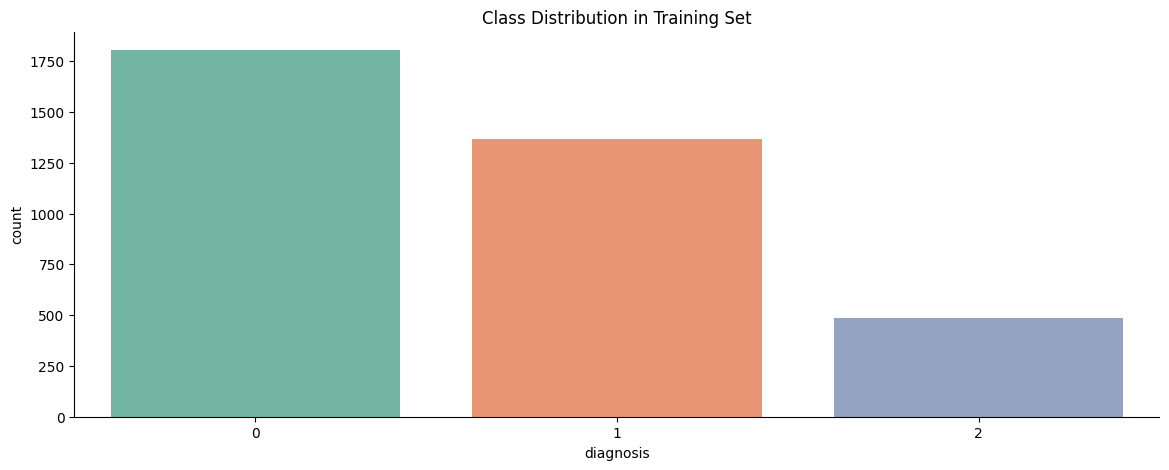

In [13]:
# Bar chart show the distribution of classes
f, ax = plt.subplots(figsize=(14, 5))
ax = sns.countplot(x="diagnosis", data=train, palette="Set2")
sns.despine()
plt.title("Class Distribution in Training Set")
plt.show()

In [14]:
train['diagnosis'] = train['diagnosis'].astype('str')

# Images Loading and Processing

In [15]:
X = []
y = []

for i, row in tqdm(train.sample(len(train)).iterrows()):
    image_name = row.id_code
    image_path = os.path.join("/kaggle/input/aptos2019-blindness-detection/train_images", image_name)
    label = row.diagnosis

    # Read image
    image = cv2.imread(image_path)
    if image is not None:  # Check if image is loaded properly
        # Convert image to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Resize image to the defined IMAGE_SIZE
        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))

        # Rescale pixel values to the range [0, 1]
        image = image / 255.0

        # Append processed image and label to respective lists
        X.append(image)
        y.append(label)
    else:
        print(f"Image not found or unable to read: {image_path}")

# Convert lists to NumPy arrays
X = np.array(X, dtype='float32')
y = np.array(y, dtype='int32')

print(f"Shape of X (images): {X.shape}")
print(f"Shape of y (labels): {y.shape}")

3662it [06:33,  9.30it/s]


Shape of X (images): (3662, 224, 224, 3)
Shape of y (labels): (3662,)


In [16]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# One-hot encode the labels
y_encoded = to_categorical(y, num_classes=NUM_CLASSES)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y)

print(f"Shape of X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}, y_test: {y_test.shape}")

Shape of X_train: (2929, 224, 224, 3), y_train: (2929, 3)
Shape of X_test: (733, 224, 224, 3), y_test: (733, 3)


In [17]:
# Define the ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=30,       # Random rotation
    width_shift_range=0.2,   # Horizontal shift
    height_shift_range=0.2,  # Vertical shift
    shear_range=0.2,         # Shearing
    zoom_range=0.2,          # Random zoom
    horizontal_flip=True,    # Horizontal flipping
    fill_mode="nearest"      # Fill mode for empty pixels
)

# Test data generator (no augmentation, only rescaling if needed)
test_datagen = ImageDataGenerator()

# Creating data generators
train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_generator = test_datagen.flow(
    X_test, y_test,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("Data generators are ready.")

Data generators are ready.


In [18]:
# Calculating class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train['diagnosis']),
    y=train['diagnosis']
)
class_weights_dict = dict(zip(np.unique(train['diagnosis']), class_weights))
print("Class Weights:", class_weights_dict)

Class Weights: {'0': 0.676269621421976, '1': 0.8916484051619187, '2': 2.501366120218579}


# Unbalanced Data Modeling

## a) Multi Classification Modelling

In [19]:
# Model building function
def build_fusion_model(num_classes, input_shape=(224, 224, 3), dropout_rate=0.5):
    input_layer = Input(shape=input_shape)

    # EfficientNetB0
    efficient_net = EfficientNetB0(include_top=False, input_tensor=input_layer, weights='imagenet')

    i = 0
    for i, layer in enumerate(efficient_net.layers):
      if i < 10:
        layer.trainable = True
        i += 1
      else:
        layer.trainable = False
    efficient_output = GlobalAveragePooling2D()(efficient_net.output)

    # InceptionV3
    inception_v3 = InceptionV3(include_top=False, input_tensor=input_layer, weights='imagenet')
    i = 0
    for i, layer in enumerate(inception_v3.layers):
      if i < 10:
        layer.trainable = True
        i += 1
      else:
        layer.trainable = False
    inception_output = GlobalAveragePooling2D()(inception_v3.output)

    # Concatenate outputs
    combined_output = concatenate([efficient_output, inception_output])

    # Fully connected layers with dropout
    x = Dense(256, activation='relu')(combined_output)
    x = Dropout(dropout_rate)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(dropout_rate)(x)

    # Output Layer
    if num_classes == 2:
        output_layer = Dense(1, activation='sigmoid')(x)
    else:
        output_layer = Dense(NUM_CLASSES, activation='softmax')(x)
        
    model = Model(inputs=input_layer, outputs=output_layer)

    return model

In [20]:
# Building the fusion model
fusion_model = build_fusion_model(input_shape=(224, 224, 3), num_classes=3 , dropout_rate=0.5)

# Compile the model 
fusion_model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Function to create callbacks
def create_callbacks(checkpoint_path):
    # Create a ModelCheckpoint callback
    checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_path,  # Path to save the model
        monitor='val_loss',       # Metric to monitor
        save_best_only=True,      # Save only the best model
        mode='min',               # Mode to minimize val_loss
        verbose=1                 # Print saving details
    )
    
    # Create an EarlyStopping callback
    early_stopping_callback = EarlyStopping(
        monitor='val_loss',       # Metric to monitor
        patience=7,               # Number of epochs with no improvement to stop
        mode='min',               # Mode to minimize val_loss
        verbose=1                 # Print stopping details
    )

    return checkpoint_callback, early_stopping_callback

# Creating callbacks
checkpoint_path = "best_fusion_model.keras"
checkpoint_callback, early_stopping_callback = create_callbacks(checkpoint_path)

In [22]:
# Training the model 
history = fusion_model.fit(train_generator, 
                           validation_data=test_generator, 
                           epochs=EPOCHS,
                           class_weight=class_weights_dict,
                           callbacks=[checkpoint_callback, early_stopping_callback]  # Added callbacks here
                          )

Epoch 1/15


I0000 00:00:1735199403.456060      71 service.cc:145] XLA service 0x7ce070002a60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735199403.456127      71 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1:26:54 57s/step - accuracy: 0.4375 - loss: 1.5831

I0000 00:00:1735199442.218265      71 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 661ms/step - accuracy: 0.5518 - loss: 1.0374
Epoch 1: val_loss improved from inf to 0.74358, saving model to best_fusion_model.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 138s 889ms/step - accuracy: 0.5526 - loss: 1.0355 - val_accuracy: 0.7121 - val_loss: 0.7436
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.7224 - loss: 0.6537
Epoch 2: val_loss improved from 0.74358 to 0.67968, saving model to best_fusion_model.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 32s 318ms/step - accuracy: 0.7226 - loss: 0.6533 - val_accuracy: 0.7462 - val_loss: 0.6797
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.7754 - loss: 0.5679
Epoch 3: val_loss improved from 0.67968 to 0.66061, saving model to best_fusion_model.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 31s 311ms/step - accuracy: 0.7752 - loss: 0.5680 - val_accuracy: 0.7244 - val_loss: 0.6606
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.7584 - loss: 0.5506
Epoch 4: val_loss did not improve from 0

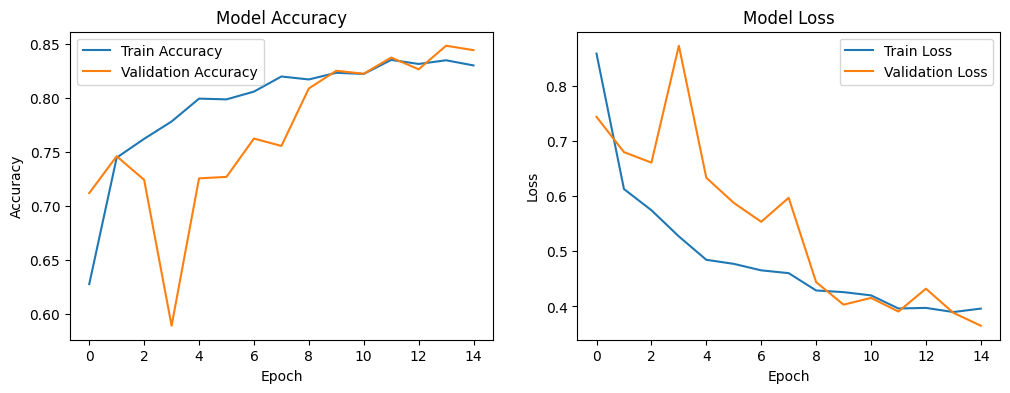

In [23]:
def plot_history(history):
    # Plotting the training and validation accuracy/loss
    plt.figure(figsize=(12, 4))
    
    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()


plot_history(history)

In [24]:
# Getting true labels and predictions
y_true = y_test.argmax(axis=1)
y_pred = np.argmax(fusion_model.predict(X_test), axis=1)
class_labels = list(label_dict.values())

23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 463ms/step


In [25]:
def evaluate_model(y_true, y_pred, class_labels):
    # Calculating accuracy, precision, recall, and F1 score
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

    # Displaying classification report
    print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_labels))

    # Generating and ploting the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Plotting the ROC curve for each class
    y_true_bin = label_binarize(y_true, classes=[0, 1, 2])
    n_classes = y_true_bin.shape[1]
    y_pred_bin = label_binarize(y_pred, classes=[0, 1, 2])
    plt.figure(figsize=(10, 6))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {label_dict[i]} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Each Class')
    plt.legend(loc='lower right')
    plt.show()

Accuracy: 0.844474761255116
Precision: 0.8374110775149887
Recall: 0.844474761255116
F1 Score: 0.8215473557902322
Classification Report:
                 precision    recall  f1-score   support

    No Disease       0.94      0.98      0.96       361
  Mild Disease       0.75      0.89      0.81       274
Severe Disease       0.71      0.22      0.34        98

      accuracy                           0.84       733
     macro avg       0.80      0.70      0.70       733
  weighted avg       0.84      0.84      0.82       733



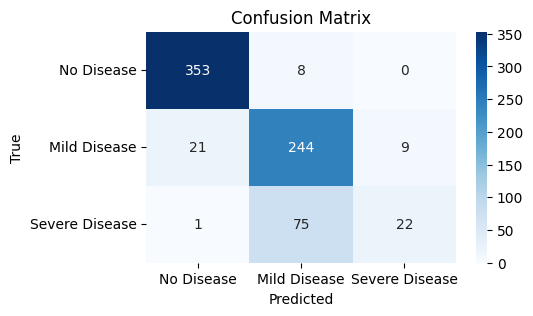

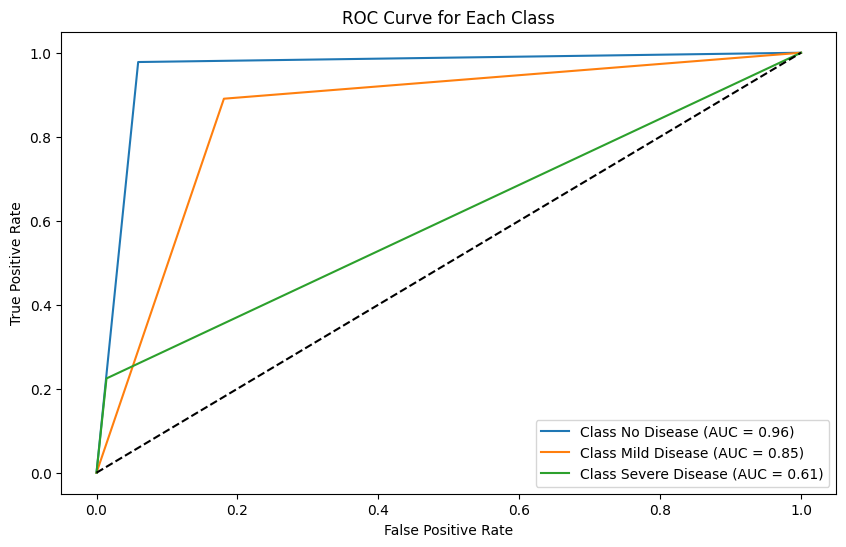

In [26]:
evaluate_model(y_true, y_pred, class_labels)

## b) Binary Classification Modelling

In [27]:
y_binary = [0 if i==0 else 1 for i in y]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42, stratify=y)

# Creating data generators
train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_generator = test_datagen.flow(
    X_test, y_test,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("Data generators are ready.")

Data generators are ready.


In [28]:
# Calculating class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_binary),
    y=y_binary
)
class_weights_dict = dict(zip(np.unique(train['diagnosis']), class_weights))
print("Class Weights:", class_weights_dict)

Class Weights: {'0': 1.014404432132964, '1': 0.9859989229940764}


In [29]:
# Building the fusion model
fusion_model = build_fusion_model(input_shape=(224, 224, 3), num_classes=2, dropout_rate=0.5)

# Compile the model 
fusion_model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy', metrics=['accuracy'])

In [30]:
# Creating callbacks
checkpoint_path = "best_fusion_model.keras"
checkpoint_callback, early_stopping_callback = create_callbacks(checkpoint_path)

In [31]:
# Training the model 
history = fusion_model.fit(train_generator, 
                           validation_data=test_generator, 
                           epochs=EPOCHS,
                           class_weight=class_weights_dict,
                           callbacks=[checkpoint_callback, early_stopping_callback]  # Added callbacks here
                          )

Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.6560 - loss: 0.6065
Epoch 1: val_loss improved from inf to 0.45411, saving model to best_fusion_model.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 115s 746ms/step - accuracy: 0.6571 - loss: 0.6051 - val_accuracy: 0.8458 - val_loss: 0.4541
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.8830 - loss: 0.2888
Epoch 2: val_loss improved from 0.45411 to 0.38277, saving model to best_fusion_model.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 31s 315ms/step - accuracy: 0.8831 - loss: 0.2885 - val_accuracy: 0.8554 - val_loss: 0.3828
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.9200 - loss: 0.2087
Epoch 3: val_loss improved from 0.38277 to 0.37844, saving model to best_fusion_model.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 31s 316ms/step - accuracy: 0.9200 - loss: 0.2087 - val_accuracy: 0.8417 - val_loss: 0.3784
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.9476 - loss: 0.1580
Epoch 4: val_loss did not imp

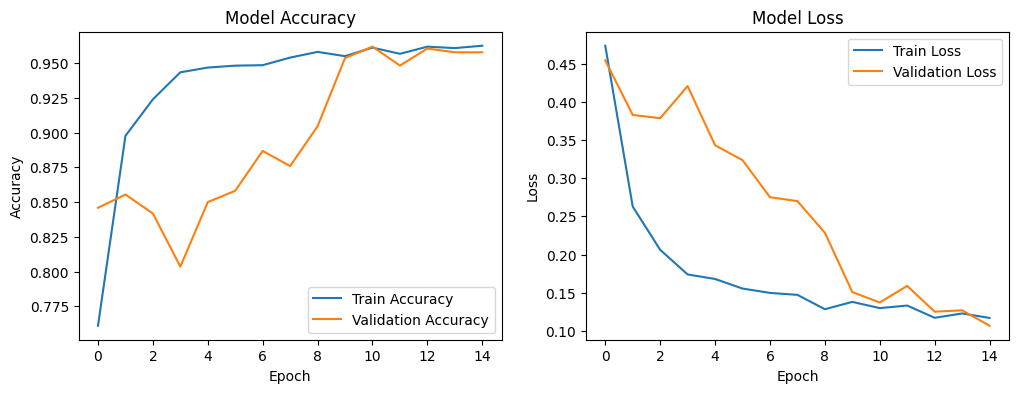

In [32]:
plot_history(history)

23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 442ms/step
Accuracy: 0.9577080491132333
Precision: 0.9578871433249343
Recall: 0.9577080491132333
F1 Score: 0.9577102531596395
Classification Report:
               precision    recall  f1-score   support

       No DR       0.95      0.97      0.96       361
          DR       0.97      0.95      0.96       372

    accuracy                           0.96       733
   macro avg       0.96      0.96      0.96       733
weighted avg       0.96      0.96      0.96       733



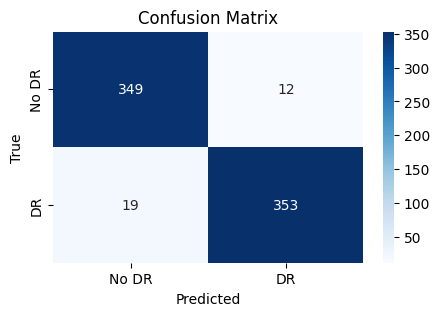

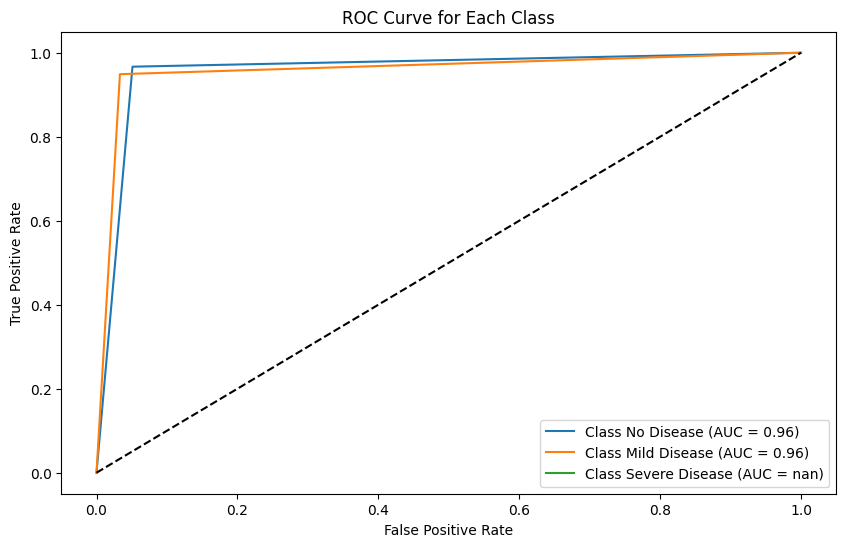

In [33]:
# Getting true labels and predictions
y_true = y_test
y_pred = [0 if i<0.5 else 1 for i in fusion_model.predict(X_test)]
class_labels = ["No DR", "DR"]
evaluate_model(y_true, y_pred, class_labels)

## c) No DR vs Severe Class Modelling

In [34]:
# Combining classes into 3 categories
df_binary = df_origional[df_origional.diagnosis.isin([0, 4])]
df_binary.replace({4: 1}, inplace=True)

X_binary = []
y_binary = []

for i, row in tqdm(df_binary.sample(len(df_binary)).iterrows()):
    image_name = row.id_code
    image_path = os.path.join("/kaggle/input/aptos2019-blindness-detection/train_images", image_name)
    label = row.diagnosis

    # Read image
    image = cv2.imread(image_path)
    if image is not None:  # Check if image is loaded properly
        # Convert image to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Resize image to the defined IMAGE_SIZE
        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))

        # Rescale pixel values to the range [0, 1]
        image = image / 255.0

        # Append processed image and label to respective lists
        X_binary.append(image)
        y_binary.append(label)
    else:
        print(f"Image not found or unable to read: {image_path}")

# Convert lists to NumPy arrays
X_binary = np.array(X_binary, dtype='float32')
y_binary = np.array(y_binary, dtype='int32')

print(f"Shape of X (images): {X_binary.shape}")
print(f"Shape of y (labels): {y_binary.shape}")

2100it [02:29, 14.08it/s]


Shape of X (images): (2100, 224, 224, 3)
Shape of y (labels): (2100,)


In [35]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_binary, y_binary, test_size=0.2, random_state=42, stratify=y_binary)

print(f"Shape of X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}, y_test: {y_test.shape}")

Shape of X_train: (1680, 224, 224, 3), y_train: (1680,)
Shape of X_test: (420, 224, 224, 3), y_test: (420,)


In [36]:
# Creating data generators
train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_generator = test_datagen.flow(
    X_test, y_test,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("Data generators are ready.")

Data generators are ready.


In [37]:
# Calculating class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_binary),
    y=y_binary
)
class_weights_dict = dict(zip(np.unique(y_binary), class_weights))
print("Class Weights:", class_weights_dict)

Class Weights: {0: 0.5817174515235457, 1: 3.559322033898305}


In [38]:
# Building the fusion model
fusion_model = build_fusion_model(input_shape=(224, 224, 3), num_classes=2, dropout_rate=0.5)

# Compile the model 
fusion_model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy', metrics=['accuracy'])

In [39]:
# Creating callbacks
checkpoint_path = "best_fusion_model.keras"
checkpoint_callback, early_stopping_callback = create_callbacks(checkpoint_path)

In [40]:
# Training the model 
history = fusion_model.fit(train_generator, 
                           validation_data=test_generator, 
                           epochs=EPOCHS,
                           class_weight=class_weights_dict,
                           callbacks=[checkpoint_callback, early_stopping_callback]  # Added callbacks here
                          )

Epoch 1/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 896ms/step - accuracy: 0.7003 - loss: 0.6671
Epoch 1: val_loss improved from inf to 0.38088, saving model to best_fusion_model.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.7011 - loss: 0.6649 - val_accuracy: 0.9095 - val_loss: 0.3809
Epoch 2/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.8563 - loss: 0.3637
Epoch 2: val_loss improved from 0.38088 to 0.31839, saving model to best_fusion_model.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 316ms/step - accuracy: 0.8566 - loss: 0.3629 - val_accuracy: 0.9167 - val_loss: 0.3184
Epoch 3/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.8905 - loss: 0.2512
Epoch 3: val_loss improved from 0.31839 to 0.29049, saving model to best_fusion_model.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 317ms/step - accuracy: 0.8906 - loss: 0.2513 - val_accuracy: 0.9167 - val_loss: 0.2905
Epoch 4/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.9369 - loss: 0.1876
Epoch 4: val_loss improved from 

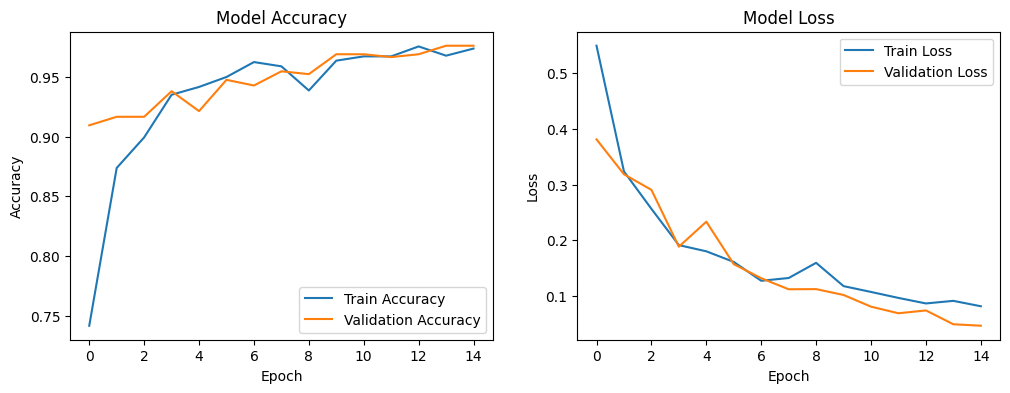

In [41]:
plot_history(history)

14/14 ━━━━━━━━━━━━━━━━━━━━ 17s 709ms/step
Accuracy: 0.9761904761904762
Precision: 0.9761904761904762
Recall: 0.9761904761904762
F1 Score: 0.976190476190476
Classification Report:
               precision    recall  f1-score   support

       No DR       0.99      0.99      0.99       361
          DR       0.92      0.92      0.92        59

    accuracy                           0.98       420
   macro avg       0.95      0.95      0.95       420
weighted avg       0.98      0.98      0.98       420



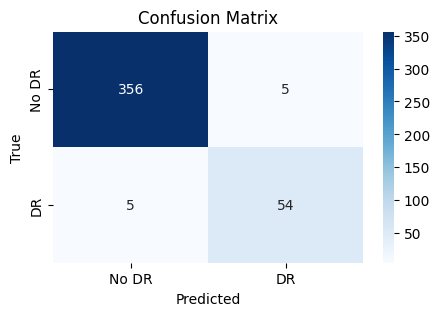

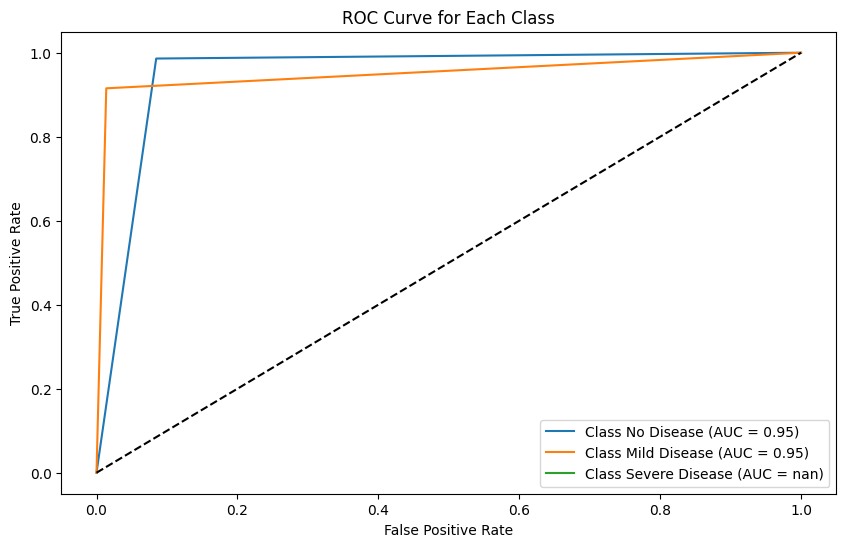

In [42]:
# Getting true labels and predictions
y_true = y_test
y_pred = [0 if i<0.5 else 1 for i in fusion_model.predict(X_test)]
class_labels = ["No DR", "DR"]
evaluate_model(y_true, y_pred, class_labels)

In [43]:
del(X_binary)
del(y_binary)

# Balanced Data Modelling

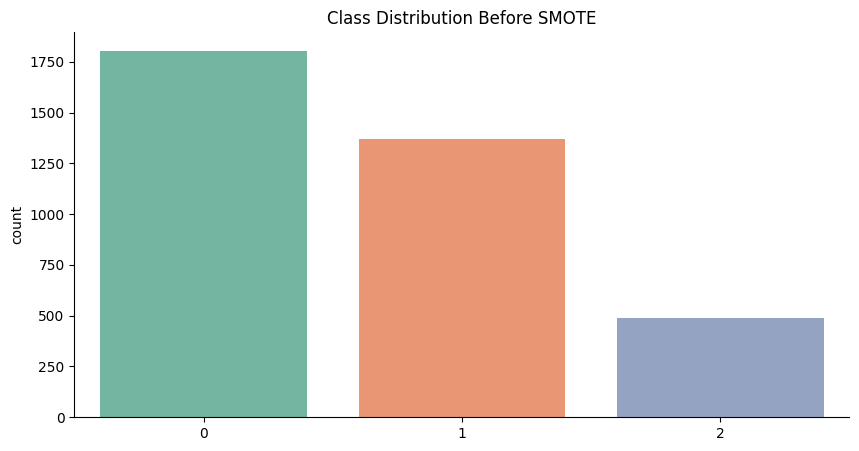

In [44]:
from imblearn.over_sampling import SMOTE

# Plot class distribution before SMOTE
plt.figure(figsize=(10, 5))
plt.title("Class Distribution Before SMOTE")
sns.countplot(x=y, palette="Set2")
sns.despine()
plt.show()

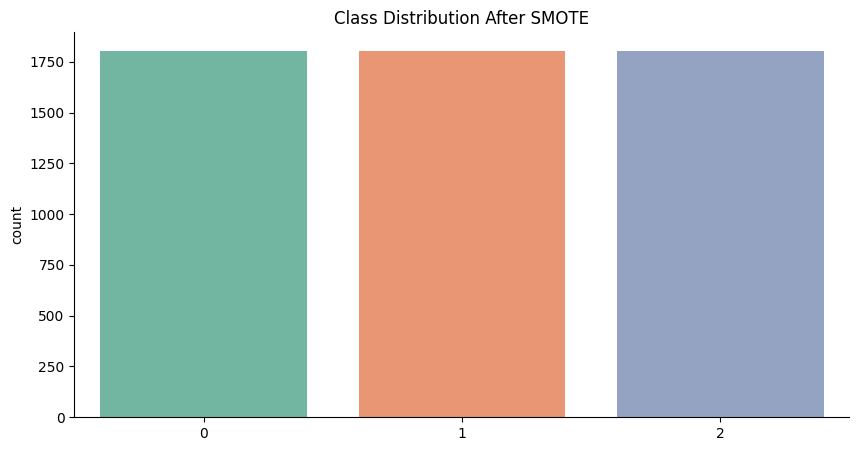

In [45]:
# SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X.reshape(X.shape[0], -1), y)

# Plot class distribution after SMOTE
plt.figure(figsize=(10, 5))
plt.title("Class Distribution After SMOTE")
sns.countplot(x=y_smote, palette="Set2")
sns.despine()
plt.show()

In [46]:
# Reshape X_smote back to original image dimensions
X_smote = X_smote.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 3)

# Encode updated y using one-hot encoding
y_smote_encoded = to_categorical(y_smote, num_classes=NUM_CLASSES)

# Split the balanced dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_smote, y_smote_encoded, test_size=0.2, random_state=42, stratify=y_smote
)

print(f"Shape of X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}, y_test: {y_test.shape}")

Shape of X_train: (4332, 224, 224, 3), y_train: (4332, 3)
Shape of X_test: (1083, 224, 224, 3), y_test: (1083, 3)


In [47]:
# Create data generators
train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_generator = test_datagen.flow(
    X_test, y_test,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("Balanced data generators are ready.")


Balanced data generators are ready.


In [48]:
# Building the fusion model
balanced_fusion_model = build_fusion_model(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), 
    num_classes= NUM_CLASSES , 
    dropout_rate=0.5
)

# Compile the model 
balanced_fusion_model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [49]:
# Creating callbacks
checkpoint_path = "best_balanced_fusion_model.keras"
checkpoint_callback, early_stopping_callback = create_callbacks(checkpoint_path)

In [50]:
# Training the model 
history_balanced = balanced_fusion_model.fit(train_generator, 
                           validation_data=test_generator, 
                           epochs=EPOCHS,
                           class_weight=class_weights_dict,
                           callbacks=[checkpoint_callback, early_stopping_callback]  # Added callbacks here
                          )

Epoch 1/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 536ms/step - accuracy: 0.3689 - loss: 1.5545
Epoch 1: val_loss improved from inf to 1.01929, saving model to best_balanced_fusion_model.keras
136/136 ━━━━━━━━━━━━━━━━━━━━ 139s 689ms/step - accuracy: 0.3692 - loss: 1.5534 - val_accuracy: 0.3527 - val_loss: 1.0193
Epoch 2/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.4701 - loss: 1.2392
Epoch 2: val_loss improved from 1.01929 to 0.83004, saving model to best_balanced_fusion_model.keras
136/136 ━━━━━━━━━━━━━━━━━━━━ 45s 317ms/step - accuracy: 0.4704 - loss: 1.2388 - val_accuracy: 0.5900 - val_loss: 0.8300
Epoch 3/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.5457 - loss: 1.1476
Epoch 3: val_loss improved from 0.83004 to 0.75665, saving model to best_balanced_fusion_model.keras
136/136 ━━━━━━━━━━━━━━━━━━━━ 45s 314ms/step - accuracy: 0.5458 - loss: 1.1473 - val_accuracy: 0.6168 - val_loss: 0.7567
Epoch 4/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.5748 - l

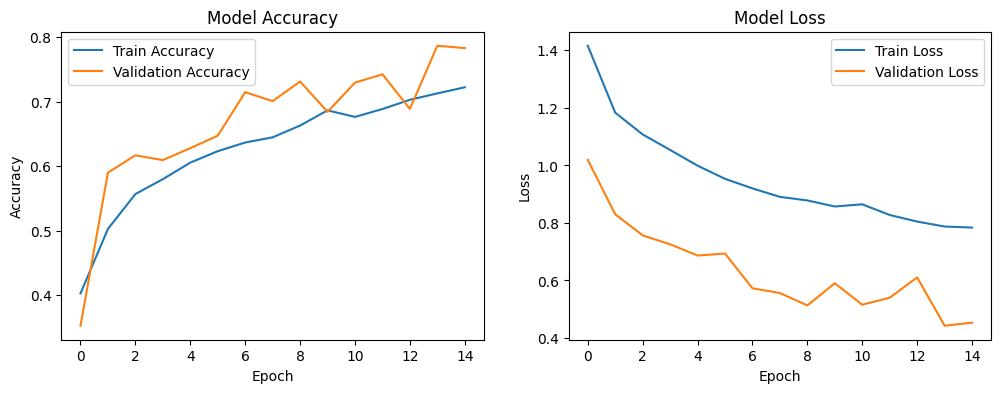

In [51]:
plot_history(history_balanced)

34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 198ms/step
Accuracy: 0.3333333333333333
Precision: 0.1111111111111111
Recall: 0.3333333333333333
F1 Score: 0.16666666666666666
Classification Report:
                 precision    recall  f1-score   support

    No Disease       0.33      1.00      0.50       361
  Mild Disease       0.00      0.00      0.00       361
Severe Disease       0.00      0.00      0.00       361

      accuracy                           0.33      1083
     macro avg       0.11      0.33      0.17      1083
  weighted avg       0.11      0.33      0.17      1083



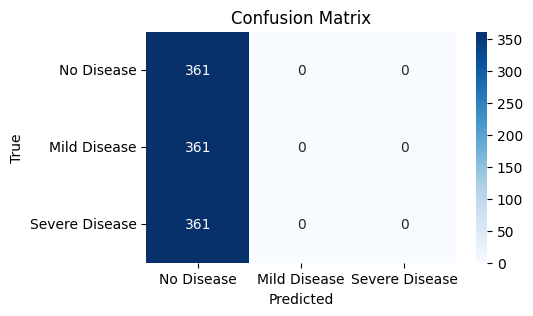

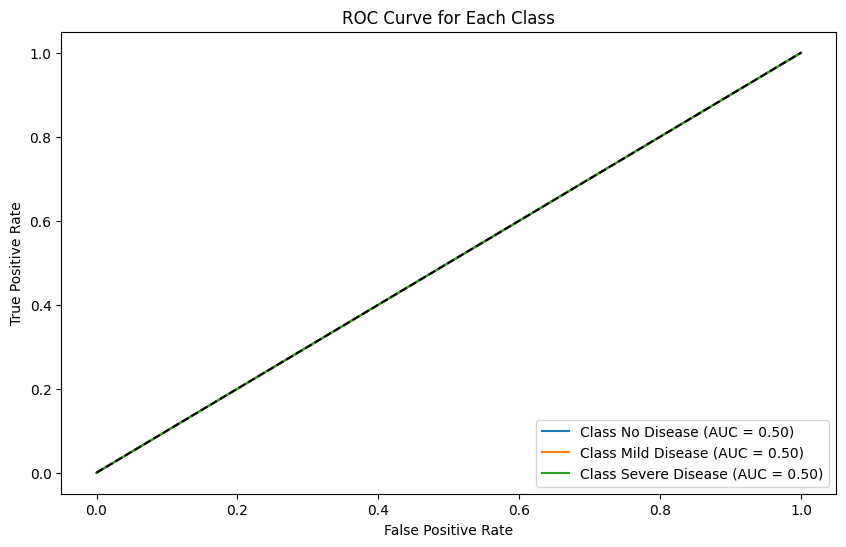

In [52]:
# Getting true labels and predictions
y_true = y_test.argmax(axis=1)
y_pred = np.argmax(fusion_model.predict(X_test), axis=1)
class_labels = list(label_dict.values())

evaluate_model(y_true, y_pred, class_labels)